In [1]:
import sys
import time as clock

class ProgressBar:
    
    def __init__(self, total_iterations):
        
        self.total_iterations = total_iterations
        self.current_iteration = 0
        self.start_time = clock.time()
        
    def step(self):
        
        self.current_iteration += 1
        self.show_progress()
        if self.current_iteration == self.total_iterations:
            self.end_time = clock.time()
            print(f'\Total time taken: {self.end_time -self.start_time} seconds')
    
    def show_progress(self):
        
        percent_complete = self.current_iteration / self.total_iterations
        num_bars = int(percent_complete * 20)
        sys.stdout.write('\r')
        sys.stdout.write(f"Progress: [{'=' * num_bars}{' ' * (20 - num_bars)}]{int(percent_complete * 100)}%")
        sys.stdout.flush()
    
        

In [2]:
import numpy
import sympy
from sympy import init_printing
init_printing()

from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

#animation
import matplotlib
from matplotlib import animation
from IPython.display import HTML

from sympy.utilities.lambdify import lambdify

In [3]:
class QuantumTunnellingSimulator:
    
    def __init__(self, time, Delta_x, Delta_t ):
       
        self.e_mass       = 1e-30                          # massa dell'elettrone
        self.vg           = 1e-1                           # velocità di gruppo (m/s)
        self.momentum     = self.vg * self.e_mass          # quantità di moto (kg * m/s) 
        self.plank_redux  = 1.054e-34                      # costante di Planck ridotta (J * s) 
        self.width0       = 2e-2                           # dispersione iniziale (m) 

        self.T            = time                           # tempo di simulazione (s)
        self.dx           = Delta_x                        # passo spaziale (m)
        self.dt           = Delta_t                        # passo temporale
        self.x_0          = 1e-1                           # posizione di partenza (m) 
        self.x_min        = 0                              # posizione iniziale (m)
        self.x_max        = 1                              # pozizione finale (m)
        self.nx           = int(self.x_max / self.dx) + 1  # numero di punti della griglia
        self.nt           = int(self.T / self.dt)          # passi temporali totali
        
        self.x_values     = numpy.linspace(self.x_min, self.x_max , self.nx) 
        
        self.K            = (self.momentum**2) / (2 * self.e_mass)  # energia cinetica delle particelle
        self.v0           = numpy.array([0 * self.K, -2 * self.K, -1 * self.K, -1/2 * self.K,
                                         1 * self.K, 1/2 * self.K, 2 * self.K])
        
        self.psi          = None
        self.real_psi     = None
        self.imag_psi     = None
        self.probab_distr = None 
      
    # FUNZIONI RICHIESTE DA: ASSIGNMENT_0: WRITE DOWN CODE
    
    # method to set the initial values of wavefunction
    def initialize_wavefunction(self, x, x0, sigma0, p0, h):
        
        wave_packet = sympy.exp(-((x-x0)**2 / (4 * sigma0**2))) / sympy.sqrt(sympy.sqrt(2 * sympy.pi) * sigma0) 
        exponential = sympy.exp((p0 * 1j * (x-x0)/ h))
        wave        = wave_packet * exponential
        wave_lamb   = lambdify((x0, x, p0, sigma0, h), wave)
        
        self.psi    = numpy.asarray([wave_lamb(self.x_0, x, self.momentum, self.width0, self.plank_redux) 
                                     for x in self.x_values])
        
    # method to evolving by one step the values of psi
    def evolve_one_step(self, dt, dx, v):
    
        un       = numpy.empty(self.nx)
        en       = numpy.empty(self.nx)
    
        self.real_psi = numpy.real(self.psi)
        self.imag_psi = numpy.imag(self.psi)
        
        #parte reale
        en = self.imag_psi.copy()
        self.real_psi[1:-1] +=  - (self.plank_redux / (2 * self.e_mass)) * dt / \
                               dx**2*(en[2:] - 2*en[1:-1] + en[0:-2]) \
                               + (dt / self.plank_redux) * v[1:-1] * en[1:-1]
        #At the boundary
        self.real_psi[0]    = 0
        self.real_psi[-1]   = 0
    
        #parte immaginaria
        un = self.real_psi.copy()   
        self.imag_psi[1:-1] +=  (self.plank_redux / (2 * self.e_mass)) * dt / \
                                dx**2*(un[2:] - 2*un[1:-1] + un[0:-2]) \
                                - (dt / self.plank_redux) * v[1:-1] * un[1:-1]
        #At the boundary    
        self.imag_psi[0]    = 0
        self.imag_psi[-1]   = 0  
    
    # method to calculate probability distribution
    def probability_distribution(self):
        self.psi = self.real_psi + 1j * self.imag_psi
        self.probab_distr = abs(self.psi)**2
        
    # method to plotting probability distribution, and the real and imaginary part of psi
    def plot_wavefunction(self):
        pyplot.plot(self.x_values, self.probab_distr, color='#003366', ls='-', lw=3)
        pyplot.plot(self.x_values, self.real_psi, color='#003366', ls='-', lw=3)
        pyplot.plot(self.x_values, self.imag_psi, color='#003366', ls='-', lw=3)
    
    # method to integrating probability distribution over dx       
    def integrate_probability_distribution(self):
        return numpy.sum(self.probab_distr) * (self.x_values[1] - self.x_values[0])
        
    
    #---------------------------------------------------------------------------metodi aggiuntivi
    
    # methode to initialize wavefunction with modified amplitude
    def initialize_wavefunction_amplitude(self, x, x0, sigma0, p0, h, t, M, amplitude):
        
        wave_packet = sympy.exp(-((x-x0)**2 / (4 * sigma0**2))) / sympy.sqrt(sympy.sqrt(2 * sympy.pi) * sigma0) 
        exponential = sympy.exp((p0 * 1j * (x-x0)/ h))
        wave        = amplitude * wave_packet * exponential
        wave_lamb   = lambdify((x0, x, p0, sigma0, h), wave)
        
        self.psi    = numpy.asarray([wave_lamb(self.x_0, x, self.momentum, self.width0, self.plank_redux) 
                                     for x in self.x_values])
    
    # method to initialize the exact probability of distribution
    def initialize_distribution_exact(self, x, x0, sigma0, p0, h, t, M):
        return sigma0 / sympy.sqrt(2 * sympy.pi) * sympy.exp(-(sigma0**2 * (x - ((p0 * t) / M))**2) / \
               (2 * ( sigma0**4 + (t**2 * h**2) / (4 * M**2) ))) / sympy.sqrt(sigma0**4 + (t**2 * h**2) / (4 * M**2) ) 
    
    # method to simulate the exact probability of distribution
    def simulate_distribuition_exact(self, distribution_exact, x, x0, sigma0, p0, h, dt, t , M, num_steps):
        distrib_ex_lamb = lambdify((x0, x, p0, sigma0, h, t , M), distribution_exact)
        return numpy.asarray([distrib_ex_lamb(self.x_0, x, self.momentum, self.width0, self.plank_redux,
                              num_steps * dt, self.e_mass) for x in self.x_values])
    
    # method to plotting probability of distribution
    def plot_distribuition_exact(self, distribution_exact):
        pyplot.plot(self.x_values, distribution_exact, color='r', ls='--', lw=2)
    
    def plot_psi(self):
        pyplot.plot(self.x_values, abs(self.psi)**2, color='#003366', ls='-', lw=2)
    
    # method to setting potential energy 
    def set_potential(self, num_potential):
        v = numpy.ones(self.nx) 
        v[numpy.intersect1d(numpy.where(self.x_values >= 5.0 * 10**-1), 
                            numpy.where(self.x_values <= 5.5 * 10**-1))] = self.v0[num_potential]
    
        v[numpy.where( self.x_values < 5.0 * 10**-1 )] = 0
        v[numpy.where( self.x_values > 5.5 * 10**-1 )] = 0
        
        return v  
    
    # method to plotting potential energy
    def plot_potential(self, potential):
        pyplot.plot(self.x_values, potential, color='#003366', ls='-', lw=2)
    
    # set time simulation
    def set_time(self, time):
        self.T = time
        
    # set number of steps 
    def set_num_steps(self, steps):
        self.nt = steps
        

In [4]:
time      = 8                     # impostiamo il tempo di simulazione
Delta_x   = 1e-4                  
Delta_t   = 9e-5   
num_steps = int(time / Delta_t)   # impostiamo il numero di passi temporali totali
x, x0, sigma0, p0, h, t, M = sympy.symbols('x x0 sigma0 p0 h t M')

# costruiamo l'oggetto QuantumTunnellingSimulator
simulator = QuantumTunnellingSimulator(time, Delta_x, Delta_t)


In [5]:
# e) visualizzare il grafico per L2_norm

def L2_error(Psi, Psi_exact):
    """Computes L2 norm of error
    
    Parameters:
    ----------
    Psi      : array of complex
        array with numerical solution
    Psi_exact: array of complex
        array with exact solution
    Returns:
    -------
    error: L2 norm of error
    """
    
    error = numpy.sqrt(numpy.sum((Psi-Psi_exact)**2)/numpy.sum(Psi_exact**2))
    
    return abs(error)

In [12]:
def check_convergence(T, dt_values, nt_values, psi_ex, V, x, x0, sigma0, p0, h, t, M):

    dt_values = dt_values
    nt_values = nt_values
    
    # numero di celle dove depositare i risultati di L2...
    error = numpy.zeros(len(dt_values))
    
    for i, dt in enumerate(dt_values):
        
        print(dt)
        # Poniamo le condizioni iniziali della soluzione numerica
        simulator.initialize_wavefunction(x, x0, sigma0, p0, h)
    
        # calcoliamo la soluzione numerica
        pb = ProgressBar(int(nt_values[i]))
        for n in range(int(nt_values[i])):
            simulator.evolve_one_step(dt, Delta_x, V)
            pb.step()
    
        # calcoliamo la soluzione analitica
        Psi_exact = simulator.simulate_distribuition_exact(psi_ex, x, x0, sigma0, p0, h, dt, 
                                                           t , M, ( (T + 1) / dt) + 1)
        
        error[i] = L2_error(simulator.psi, Psi_exact)
        
    return error

In [13]:
# impostiamo i valori iniziali
time      = 1                    
num_steps = int(time / Delta_t)

simulator.set_time(time)                      # reimpostiamo il tempo di simulazione
simulator.set_num_steps(num_steps)            # reimpostiamo il numero di passi temporali totali

num_v0    = 0
potential = simulator.set_potential(num_v0)
dt_values = numpy.asarray([9e-5, 8e-5, 7e-5, 9e-6])    
nt_values = time / dt_values

# costruiamo la funzione di distribuzione
distribution = simulator.initialize_distribution_exact(x, x0, sigma0, p0, h, t, M) 

# costruiamo la funzione d'onda da simulare
simulator.initialize_wavefunction(x, x0, sigma0, p0, h)

# verifichiamo la convergenza...
error = check_convergence(time, dt_values, nt_values, distribution, potential, x, x0, sigma0, p0, h, t, M)

9e-05
Progress: [====================]100%\Total time taken: 16.78696846961975 seconds
8e-05
Progress: [====================]100%\Total time taken: 21.85670828819275 seconds
7e-05
Progress: [====================]100%\Total time taken: 22.893173694610596 seconds
9e-06
Progress: [====================]100%\Total time taken: 230.58888959884644 seconds


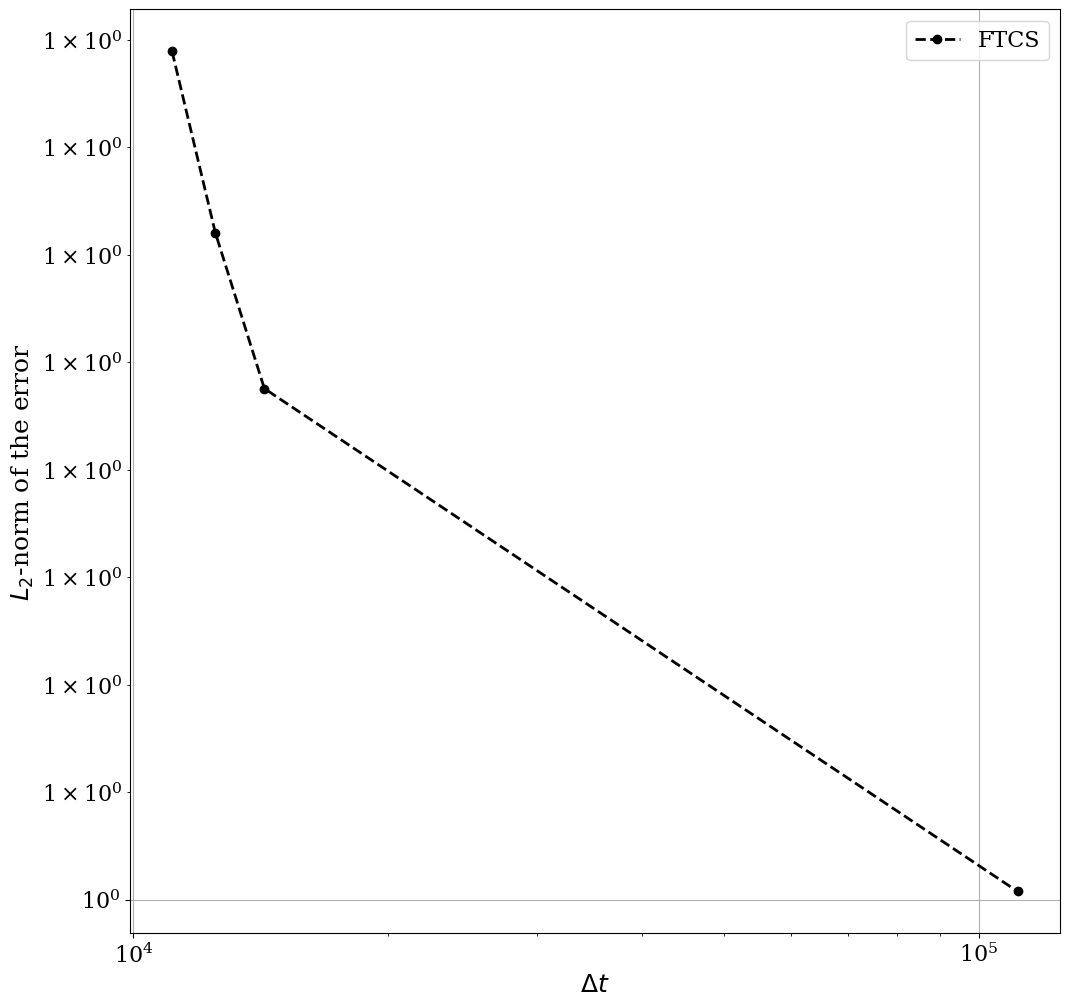

In [14]:
pyplot.figure(figsize=(12,12))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=18)
pyplot.ylabel(r'$L_2$-norm of the error', fontsize=18)
pyplot.loglog(nt_values, error, color='k', ls='--', lw=2, marker='o')
pyplot.legend(['FTCS']);